# Assignment: Unsupervised Machine Learning \ Clustering

## Part 1: Partitional Clustering

In this assignment you will experience with partitional & mixture model clustering. The analyses are made on real datasets under the circumstances of real life challenges in unsupervised machine learning.

In [3]:
import numpy as np
import pandas as pd

from sklearn.cluster import KMeans
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from sklearn.metrics import silhouette_samples, silhouette_score

### Read blood test results as an EMR from an Excel file

In [4]:
# Open the file
xlsx = pd.ExcelFile('EMR-Blood.xlsx')

# Get the first sheet as an object
sheet1 = xlsx.parse(0)

# Set the Key column as the index
sheet1.set_index("Key", inplace=True)

# Show first 10 rows
sheet1[:10]

,Na,K,ALT,AST,WBC,RBC,Hgb,Hct
Key,,,,,,,,
1,141,4.65,31.92,35.01,10.25,4.06,17.6,36.3
2,140,4.96,36.41,16.70,6.13,3.80,13.2,35.6
3,136,3.66,41.43,13.17,5.86,4.26,16.2,43.7
4,136,4.74,23.92,30.33,10.80,4.83,16.1,49.8
5,140,4.74,43.66,20.44,6.59,4.05,12.6,39.1
6,146,3.98,48.41,33.22,4.53,4.04,17.9,47.3
7,144,5.29,44.29,19.28,10.12,3.96,17.2,47.9
8,138,4.57,50.43,16.39,4.66,4.91,13.7,41.5
9,144,3.96,31.51,34.87,4.57,4.72,15.1,47.6


### Blood Test Abbreviations
- Na == Sodium
- K == Potassium
- ALT == Alanine transaminase
- AST == Aspartate transaminase
- WBC == White blood cells
- RBC == Red blood cells
- Hgb == Hemoglobin
- Hct == Hematocrit

### Use K-Means to create clusters according to variables of uniform distribution

In [5]:
# Retrieve the K, WBC and Hgb column values from the dataset to cluster
variables1 = ["K","WBC","Hgb"]
EMR3d1 = sheet1.loc[:, variables1].values

# Run the K-Means algorithm, assuming the correct number of clusters is 5
km_skl = KMeans(5, n_init='auto')
km_skl.fit(EMR3d1)
y_pred_KMeans1 = km_skl.predict(EMR3d1)

print(y_pred_KMeans1)


[2 4 0 2 4 3 2 4 3 3 2 1 3 2 4 3 2 1 3 0 2 1 3 2 4 3 2 1 0 0 2 4 0 2 4 0 2
 1 3 3 2 4 3 2 1 3 2 4 0 3 2 4 0 2 1 0 2 4 0 0 2 4 3 2 1 0 2 4 3 0 2 1 3 2
 4 0 2 4 0 3 2 1 3 2 1 0 2 4 3 0 2 1 0 2 1 0 2 4 3 0]


Distributions of variables

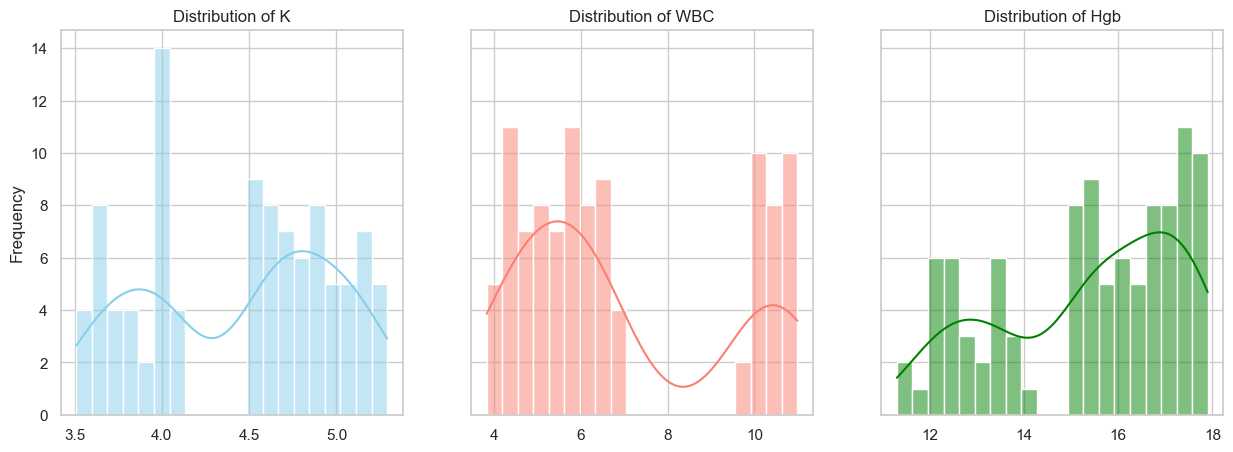

In [6]:
# Set the style for the plots (optional)
sns.set(style="whitegrid")

# Create a figure with subplots for each variable
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Extract variables from the DataFrame
AST_values = sheet1.loc[:, 'K'].values
ALT_values = sheet1.loc[:, 'WBC'].values
RBC_values = sheet1.loc[:, 'Hgb'].values

# Plot distribution bars for each variable
sns.histplot(AST_values, bins=20, kde=True, ax=axes[0], color='skyblue')
sns.histplot(ALT_values, bins=20, kde=True, ax=axes[1], color='salmon')
sns.histplot(RBC_values, bins=20, kde=True, ax=axes[2], color='green')

# Set titles for each subplot
axes[0].set_title('Distribution of K')
axes[1].set_title('Distribution of WBC')
axes[2].set_title('Distribution of Hgb')

# Set common ylabel
axes[0].set_ylabel('Frequency')

# Show the plots
plt.show()

### Make a 3D chart

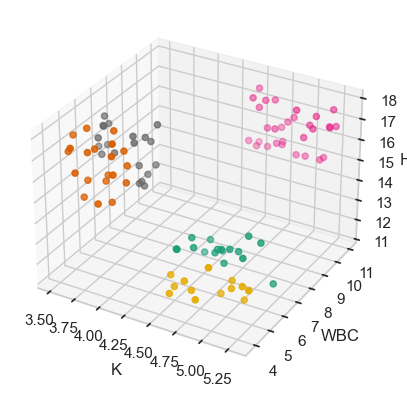

In [7]:
def make_chart (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred, cmap='Dark2_r')

make_chart(EMR3d1, y_pred_KMeans1, variables1)

## Task 1 (_max score - 50 points_)
Implement  Lloyd's Algorithm for solving the K-Means problem, as shown in class.
By examining the WCSS, choose a proper threshold to determine algorithm convergence.

Check your algorithm on 'EMR-Blood.xlsx' dataset. Compare your results to the _sklearn_ version - what can affect any differences you might've got?

In [28]:
# Add your code for task1 after this line, and keep it in this cell.

# Implement K-Means (X being the data)
class k_means:
    def __init__(self, k):
        self.k = k
        self.centroids = None
        self.wcss = None
        self.labels = None


    def fit(self, X):
    
        labels = []
        
        # Initialize centroids randomly from space of features
        numFeatures = X.shape[1]
        features_space = np.vstack([X.min(axis=0), X.max(axis=0)])
        centroids = np.random.uniform(low=features_space[0,:], high=features_space[1,:], size=(self.k, numFeatures))

        wcss = float('inf')

        # Based on a number of tests, we chose the convergence threshold
        threshold = 1e-2
        while True:
            labels = self.getLabels(X, centroids)
            centroids_new = self.getCentroids(X, labels, self.k)        
            distances = np.linalg.norm(X - centroids_new[labels], axis=1)

            wcss_new = np.sum(distances ** 2)
            wcss_change = wcss - wcss_new
            wcss = wcss_new
            centroids = centroids_new

            # Check for convergence
            if wcss_change < threshold:
                break

        self.centroids = centroids_new
        self.wcss = wcss
        self.labels = labels


    def getLabels(self, X, centroids):

        # Prepare for broadcasting
        X_ = X[..., np.newaxis]
        cent_ = centroids[..., np.newaxis].T

        # Calculate pairwise Euclidean distances
        distances = np.linalg.norm(X_ - cent_, axis=1)

        # Get nearest centroid for each point (labels due to nearest centroid)
        labels = np.argsort(distances, axis=1)[:, 0]

        return labels


    def getCentroids(self, X, labels, k):
        numFeatures = X.shape[1]
        centroids = np.zeros((k,numFeatures))
        for label in range(k):

            points_wlabel = X[labels == label, :]

            # Check if a centroid is empty, if True - randomly re-initialize it
            if len(points_wlabel) == 0:
                features_space = np.vstack([X.min(axis=0), X.max(axis=0)])
                centroids[label] = np.random.uniform(low=features_space[0,:], high=features_space[1,:], size=numFeatures)
            else:
                centroids[label] = points_wlabel.mean(axis=0)            
        return centroids


    def predict(self, X):
        return self.getLabels(X, self.centroids)

[0 4 3 0 4 2 0 1 3 2 0 4 3 0 4 2 0 1 2 3 0 1 2 0 4 3 0 4 2 3 0 4 2 0 4 3 0
 4 2 3 0 4 3 0 1 3 0 4 3 2 0 4 3 0 1 2 0 4 2 2 0 1 2 0 4 2 0 4 2 3 0 1 2 0
 4 3 0 4 2 2 0 1 2 0 1 2 0 4 3 3 0 1 3 0 1 3 0 4 2 2]


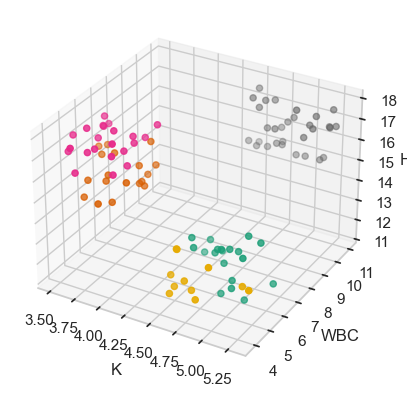

In [29]:
# Run the K-Means algorithm, assuming the correct number of clusters is 5
km_lloyd = k_means(5)
km_lloyd.fit(EMR3d1)
y_pred_KMeans2 = km_lloyd.predict(EMR3d1)

print(y_pred_KMeans2)
make_chart(EMR3d1, y_pred_KMeans2, variables1)

## Task 2 (_max score - 30 points_)

Humans can clearly spot 3 clusters, however, for machines it's much harder to "learn" that. In the above implementation, K-Means was given the value of 5 as K.
Develop a **generic** mechanism for finding the most reasonable number of clusters by:
1. Iterating K over a reasonable range, which should be derived from the number of points
2. Choose a proper K based on the heuristics learned in class
3. Showing the final clusters in a 3D chart (for your implementation of K-Means algorithm)

In [62]:
# Add your code for task2 after this line, and keep it in this cell.

def calculate_WCSS(X, plot=True):

    # Assume maximum k ~ 7% of number of points
    k_max = int(len(X)/14)

    wcss_all = []
    imp = []
    k_values = range(1, k_max + 1)
    wcss = float('inf')

    for k in k_values:
        kmeans = k_means(k)
        kmeans.fit(X)
        wcss_new = kmeans.wcss
        wcss_all.append(wcss_new)
        improvement = wcss - wcss_new
        imp.append(improvement)
    
        wcss = wcss_new

    if plot:
        # Plot WCSS vs. k
        plt.plot(k_values, wcss_all, marker='.')
        plt.title('WCSS vs. Number of Clusters (k)')
        plt.xlabel('Number of Clusters (k)')
        plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
        plt.show()    
    

    return (k_max, wcss_all)


def find_optimal_k(X):

    k_max, wcss_all = calculate_WCSS(X)
                              
    k_values = np.arange(1, k_max+1)
    wcss_all = np.asarray(wcss_all)
            
    # Coefficients of the line equation
    A = wcss_all[-1] - wcss_all[0]
    B = 1 - k_max
    C = k_max * wcss_all[0] - wcss_all[k_max-1]

    # Calculate distances from each points to the line passing through two endpoints 
    distances = np.abs(A * k_values + B * wcss_all + C) / np.sqrt(A**2 + B**2)

    optimal_k = distances.argmax() + 1

    return optimal_k

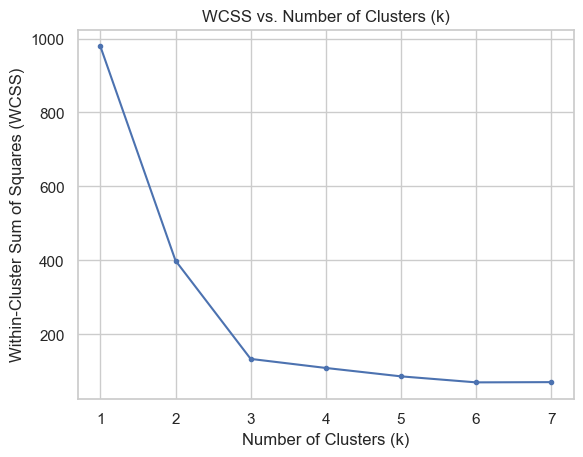

Optimal k = 3


In [63]:
optimal_k = find_optimal_k(EMR3d1)
print(f'Optimal k = {optimal_k}')



Show the final clusters in a 3D chart (for your implementation of K-Means algorithm):

[1 0 2 1 0 2 1 0 2 2 1 0 2 1 0 2 1 0 2 2 1 0 2 1 0 2 1 0 2 2 1 0 2 1 0 2 1
 0 2 2 1 0 2 1 0 2 1 0 2 2 1 0 2 1 0 2 1 0 2 2 1 0 2 1 0 2 1 0 2 2 1 0 2 1
 0 2 1 0 2 2 1 0 2 1 0 2 1 0 2 2 1 0 2 1 0 2 1 0 2 2]


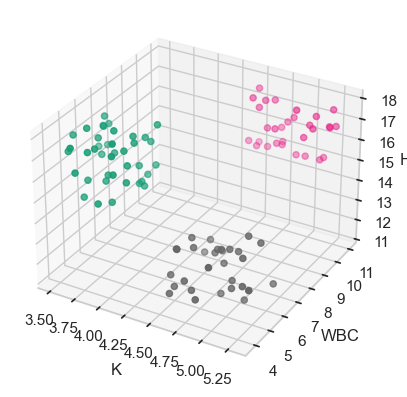

In [10]:
km_lloyd_k = k_means(3)
km_lloyd_k.fit(EMR3d1)
y_pred_KMeans3 = km_lloyd_k.predict(EMR3d1)


print(y_pred_KMeans3)
make_chart(EMR3d1, y_pred_KMeans3, variables1)

### Silhouette analysis

Use graphic visualization of the Silhouette score to support your above answer:

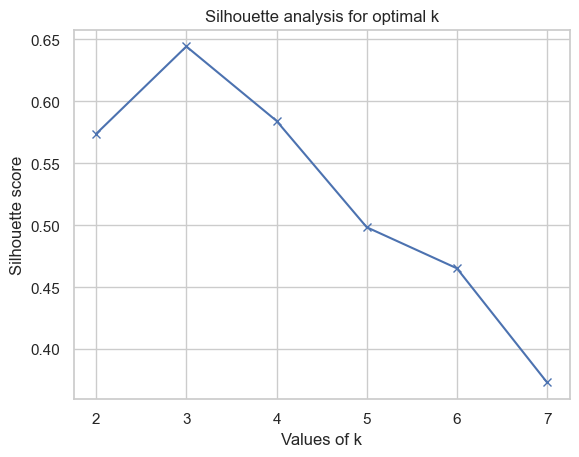

In [31]:
def optimal_k_Silhouette(X, num_clusters):

    silhouette_avg_plot = []
    k_values = np.arange(2,num_clusters+1)

    for k in k_values:
        # initialise kmeans
        kmeans = k_means(k)
        kmeans.fit(X)
        cluster_labels = kmeans.predict(X)

        silhouette_avg_plot.append(silhouette_score(X, cluster_labels))

    # silhouette score
    plt.plot(k_values,silhouette_avg_plot,'bx-')
    plt.xlabel('Values of k') 
    plt.ylabel('Silhouette score') 
    plt.title('Silhouette analysis for optimal k')
    plt.show()

optimal_k_Silhouette(EMR3d1, 7)

In [32]:
def plot_Silhouette(X, y, num_clusters):
    # YOUR CODE HERE
    
    # Calculate silhouette scores
    silhouette_avg = silhouette_score(X, y)
    print(f"For num_clusters = {num_clusters}, the average silhouette_score is: {silhouette_avg}")

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, y)

    # The vertical line for the average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    y_lower = 10
    for i in range(num_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[y == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        # Plot the silhouette scores for the current cluster
        plt.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        plt.text(-0.04, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for the next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title(f"{num_clusters} clusters", fontsize=12)
    plt.ylabel("Cluster label")
    
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    plt.yticks([])
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

For num_clusters = 2, the average silhouette_score is: 0.5738344190137955
For num_clusters = 3, the average silhouette_score is: 0.644343998493909


For num_clusters = 4, the average silhouette_score is: 0.5842886697103318
For num_clusters = 5, the average silhouette_score is: 0.49200506285494244


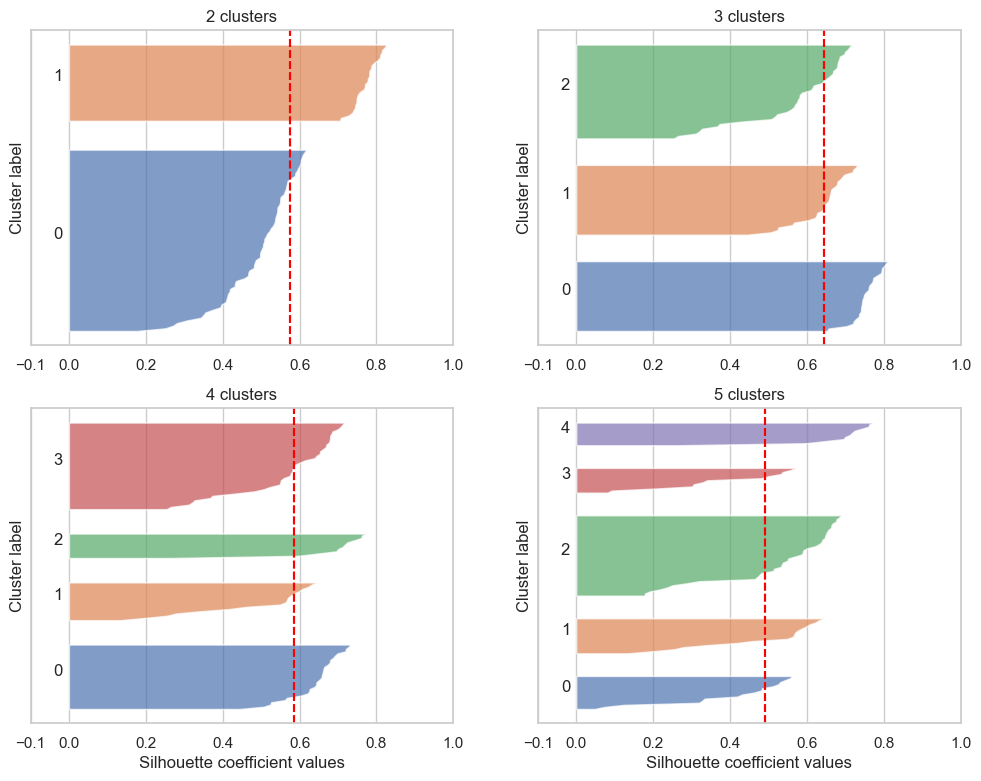

In [35]:
num_clusters = [2, 3, 4, 5]
plt.figure(figsize=(12,int(len(num_clusters)*4.5/2)))
i = 1

for k in num_clusters:
    n_km_est = k_means(k)
    n_km_est.fit(EMR3d1)
    plt.subplot(int(len(num_clusters)/2), 2, i)
    plot_Silhouette(EMR3d1, n_km_est.labels, k)
    if i in [len(num_clusters), len(num_clusters)-1]:
        plt.xlabel("Silhouette coefficient values")
    i += 1

#### From this section on - please use the sklearn's K-means

## Part 2: Mixture Models Clustering

### Use K-Means to create clusters according to variables of both uniform and Gaussian distributions

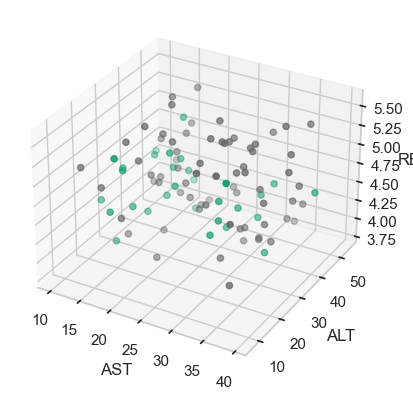

In [14]:
def make_chart_u (chart_data, y_pred, labels):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
    ax.scatter(chart_data[:,0], chart_data[:,1], chart_data[:,2], c=y_pred, cmap='cool')
    ax.view_init(elev=30, azim=90)

# Retrieve the ALT, AST and RBC column values from the dataset to cluster
variables2 = ["AST","ALT","RBC"]
EMR3d2 = sheet1.loc[:, variables2].values

# Run the K-Means algorithm
# NOTICE, this time, we know that the correct number of clusters is 2
KMeans4 = KMeans(2, n_init='auto')
KMeans4.fit(EMR3d1)
y_pred_KMeans4 = KMeans4.predict(EMR3d1)

# Make a 3D chart
make_chart (EMR3d2, y_pred_KMeans4, variables2)

## Task 3 (_max score - 20 points_)
Scientists have found that in this population of patients, RBC distribution is uniform, ALT distribution is a Gaussian and AST distribution is a mixture of two Gaussians. Clearly, even by giving K-Means the correct K, the algorithm got to the wrong conclusion. This separation is "technically" correct, but lacks some underlying understanding of the natural phenomena.

What is the "problem" with this separation?

The "problem" with the separation obtained by K-Means in this scenario lies in its assumption that the underlying data distribution in each cluster is spherical and has equal variance. However, the given information about the patient population suggests that the distributions of RBC is different from the assumptions made by K-Means.

In order to exploit the Gaussian characteristic of the AST
1. Find the 2 componenets that comprise the AST feature by applying the GMM algorithm with the proper number of components.
2. Assume that the clusters above are correct for the entire dataset (including the other features).
3. Show the final clusters (of EMR3d2) in a 3D chart

Let's first plot and check the distributions of each variable:

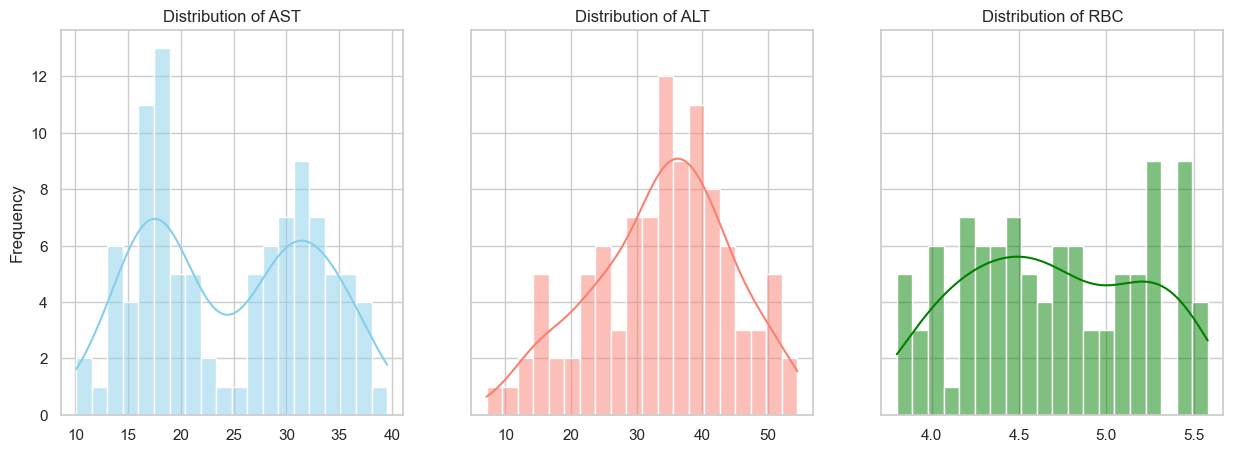

In [15]:
variables2 = ["AST","ALT","RBC"]
EMR3d2 = sheet1.loc[:, variables2].values
# Set the style for the plots (optional)
sns.set(style="whitegrid")

# Create a figure with subplots for each variable
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

# Extract variables from the DataFrame
AST_values = sheet1.loc[:, 'AST'].values
ALT_values = sheet1.loc[:, 'ALT'].values
RBC_values = sheet1.loc[:, 'RBC'].values

# Plot distribution bars for each variable
sns.histplot(AST_values, bins=20, kde=True, ax=axes[0], color='skyblue')
sns.histplot(ALT_values, bins=20, kde=True, ax=axes[1], color='salmon')
sns.histplot(RBC_values, bins=20, kde=True, ax=axes[2], color='green')

# Set titles for each subplot
axes[0].set_title('Distribution of AST')
axes[1].set_title('Distribution of ALT')
axes[2].set_title('Distribution of RBC')

# Set common ylabel
axes[0].set_ylabel('Frequency')

# Show the plots
plt.show()

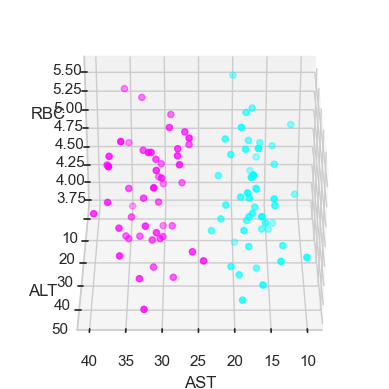

In [16]:
# Add your code for task3 after this line, and keep it in this cell.
from sklearn.mixture import GaussianMixture

# 1. Find the 2 componenets that comprise the AST feature by applying the GMM algorithm with the proper number of components.   
# as AST index is 0
X = EMR3d2[:,[0]]
gmm = GaussianMixture(2)
gmm.fit(X)
y_gmm = gmm.predict(X)

# Let's sssume that the clusters above are correct for the entire dataset, hence
# the final clusters (of EMR3d2) in a 3D chart will look like:
make_chart_u(EMR3d2, y_gmm, variables2)


- What is the difference between the two clustering results above?

The difference between the two clustering results lies in the algorithms' ability to handle the underlying distributions of the features. K-Means struggles when faced with features that have non-spherical or varied distributions, often leading to suboptimal cluster definitions. On the contrary, GMM accommodates diverse shapes and variances in the data, providing more accurate cluster definitions.

- Which one, given the domain knowledge provided to you, makes more sense?

Given the domain knowledge that some features exhibit uniform and a mixture of Gaussians, GMM is more appropriate. Its flexibility in capturing various shapes and variances aligns with the characteristics of the data, making it a suitable choice for clustering in this specific scenario.




# Good Luck!

